<a href="https://colab.research.google.com/github/Ashish996089/Food_vision_101/blob/main/Food_Vision_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d00b67b4-e3be-1d3b-9ff9-10b7ae9bdb9e)


In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-07-02 11:37:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-07-02 11:37:14 (17.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

# Use tensorflow datasets to download data

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
# List all avaialable datasets
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
# Load the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.SWZKEV_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.SWZKEV_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dataype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (384, 512, 3)
  Image dataype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 97
  Class name (str form): takoyaki
  


In [ ]:
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[ 54,  30,  26],
        [ 57,  33,  29],
        [ 72,  49,  43],
        ...,
        [192, 184, 163],
        [190, 179, 159],
        [181, 169, 147]],

       [[ 51,  28,  22],
        [ 60,  37,  31],
        [ 81,  58,  52],
        ...,
        [191, 183, 162],
        [189, 176, 157],
        [176, 164, 142]],

       [[ 78,  58,  49],
        [ 96,  76,  67],
        [122, 102,  93],
        ...,
        [191, 183, 162],
        [188, 175, 156],
        [172, 157, 136]],

       ...,

       [[162, 140, 117],
        [164, 142, 119],
        [169, 147, 126],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[168, 146, 123],
        [170, 148, 125],
        [176, 154, 131],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[173, 151, 128],
        [176, 154, 131],
        [182, 160, 137],
        ...,
        [  4,   4,   

In [ ]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Plot an image from tensorflow datasets

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

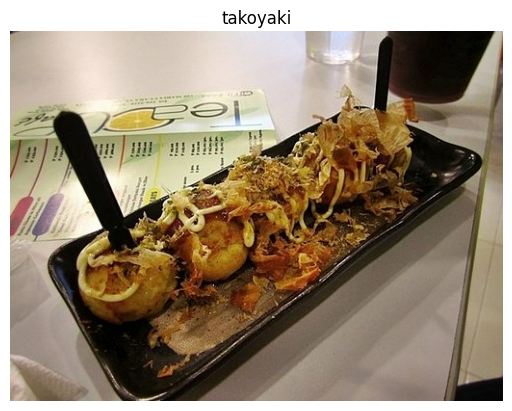

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

# Preprocessing for our data

In [ ]:
# Function for preprocessing images
def preprocess_img(image, label, img_shape=300):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  images to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return preprocess_input(image), label

In [ ]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 54  30  26]
  [ 57  33  29]
  [ 72  49  43]
  ...
  [192 184 163]
  [190 179 159]
  [181 169 147]]

 [[ 51  28  22]
  [ 60  37  31]
  [ 81  58  52]
  ...
  [191 183 162]
  [189 176 157]
  [176 164 142]]]..., 
Shape: (384, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 56.23469   32.591835  27.877552]
  [ 98.16328   75.16328   68.50001 ]
  [121.62245  101.62245   91.63265 ]
  ...
  [191.72456  191.36736  170.93883 ]
  [202.18863  196.9743   176.90286 ]
  [185.918    174.10167  153.6169  ]]

 [[ 93.47959   73.55102   64.19388 ]
  [144.57143  124.64286  113.561226]
  [169.66327  150.20409  138.79082 ]
  ...
  [196.22955  195.22955  176.80103 ]
  [202.02025  194.9335   175.87225 ]
  [182.24942  168.44324  148.72888 ]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


In [ ]:
# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

Batch and preprocess datasets

In [ ]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Create modelling callbacks

In [ ]:
checkpoint_path = "model_checkpoint/efficientnetb3_finetuned.weights.h5"

callbacks = [
    create_tensorboard_callback(dir_name="training_logs", experiment_name="EfficientNetB3_finetune"),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                       monitor="val_accuracy",
                                       save_best_only=True,
                                       save_weights_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

Setup mixed precision training

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

# Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import preprocessing

# Create base model
input_shape = (300, 300, 3)
base_model = EfficientNetB3(include_top=False)
base_model.trainable = True

# Build model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=["accuracy"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Checking layer dtype policies (are we using mixed precision?)

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


# Fit the feature extraction model

In [ ]:
history_feature_extraction = model.fit(train_data,
                                       epochs=20,
                                       validation_data=test_data,
                                       callbacks=callbacks)

Saving TensorBoard log files to: training_logs/EfficientNetB0_feature_extraction/20250702-121807
Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 207s 75ms/step - accuracy: 0.4724 - loss: 2.2907 - val_accuracy: 0.6936 - val_loss: 1.1401
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 198s 80ms/step - accuracy: 0.6659 - loss: 1.2954 - val_accuracy: 0.7145 - val_loss: 1.0379
Epoch 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 157s 65ms/step - accuracy: 0.7014 - loss: 1.1404 - val_accuracy: 0.7304 - val_loss: 0.9883
Epoch 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 201s 65ms/step - accuracy: 0.7269 - loss: 1.0375 - val_accuracy: 0.7304 - val_loss: 0.9814
Epoch 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 203s 66ms/step - accuracy: 0.7419 - loss: 0.9716 - val_accuracy: 0.7344 - val_loss: 0.9736


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


In [ ]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.7312 - loss: 0.9802


[0.9724775552749634, 0.7356435656547546]

## Plots

In [ ]:
plot_loss_curves(history_feature_extraction)

In [ ]:
pred_probs = model.predict(test_data, verbose=1)

In [ ]:
len(pred_probs)

pred_probs.shape

In [ ]:
pred_classes = pred_probs.argmax(axis=1)

pred_classes[:10]

In [ ]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  # Plot the figure
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Added: Rotate xticks for readability
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
class_names = test_data.class_names
class_names[:10]

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))